In [1]:
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U trl
!pip install -q -U peft
!pip install accelerate
!pip install wandb

In [22]:
# For dataset
import pandas as pd
import json
import os
import ast
import re
import numpy as np
from datasets import Dataset
import matplotlib.pyplot as plt

# For LLM
from peft import LoraConfig, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    set_seed,
    pipeline
)
from trl import SFTTrainer, setup_chat_format, SFTConfig

import torch
from time import time

import json
import os
from pathlib import Path

from subprocess import Popen, PIPE, STDOUT
from glob import glob

# For wandb
#from kaggle_secrets import UserSecretsClient
import wandb 
# Set seed
set_seed(42)

In [4]:
hf_token = os.getenv('HF_TOKEN')

# Check if HF_TOKEN is found
if hf_token:
    print("HF_TOKEN found")
else:
    print("HF_TOKEN is not set or found in environment variables.")

HF_TOKEN found


In [8]:
base_path='../data/'
# Loading JSON data
def load_json(file_path):
    data = {};
    for file in glob(file_path+ "*.json"):
        with open(file) as f:
            file_name = os.path.basename(file).split(".json")[0]
            data[file_name] = json.load(f)
    return data

In [9]:
# Reading files
challenges =  load_json(base_path +'training/')

In [10]:
list(challenges)[0]

'2dc579da'

In [11]:
# Prepare data for DataFrame
# Load JSON data from the files
# with open('/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json') as f:
#     challenges = json.load(f)

# with open('/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json') as f:
#     solutions = json.load(f)

data = []
for file_name, grids in challenges.items():
    train_grids = grids.get('train', [])
    test_inputs = [item['input'] for item in grids.get('test', [])]
    test_outputs = [item['output'] for item in grids.get('test', [])]

    # Transform test grids to lists of dicts with 'output' key
    test_outputs_transformed = [{'output': grid} for grid in test_outputs]
    # Combine test inputs and outputs in alternating manner
    combined_tests = []
    for test_input, test_output in zip(test_inputs, test_outputs_transformed):
        combined_tests.append({'input': test_input, 'output': test_output})
    data.append({
            'file_name': file_name,
            'train': train_grids,
            'test_input': test_inputs,
            'test_output': test_outputs_transformed,
            'test': combined_tests
    })

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

    file_name                                              train  \
0    2dc579da  [{'input': [[8, 8, 3, 8, 8], [8, 8, 3, 8, 8], ...   
1    93b581b8  [{'input': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0...   
2    36d67576  [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3    0ca9ddb6  [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0...   
4    496994bd  [{'input': [[2, 2, 2], [2, 2, 2], [3, 3, 3], [...   
..        ...                                                ...   
395  90f3ed37  [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [8...   
396  8eb1be9a  [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
397  2013d3e2  [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0...   
398  a65b410d  [{'input': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0...   
399  fafffa47  [{'input': [[0, 9, 9], [0, 9, 9], [9, 9, 9], [...   

                                            test_input  \
0    [[[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1,...   
1    [[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, ...   
2    [[[0

In [12]:
# Define a template for formatting chat messages with the Llama 3 model
# This is model specific. Change it if you e.g. use Google's Gemma instead of Llama
LLAMA_3_CHAT_TEMPLATE = """{% set loop_messages = messages %}{% for message in loop_messages %}{% set content = '<|start_header_id|>' + message['role'] + '<|end_header_id|>\n\n'+ message['content'] | trim + '<|eot_id|>' %}{% if loop.index0 == 0 %}{% set content = bos_token + content %}{% endif %}{{ content }}{% endfor %}{% if add_generation_prompt %}{{ '<|start_header_id|>assistant<|end_header_id|>\n\n' }}{% endif %}"""

# Set the data type for computations to float16, bfloat16 not supported on T4/P100
compute_dtype = getattr(torch, "float16")

# Configure the BitsAndBytes settings for 4-bit quantization to reduce memory usage
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enable 4-bit quantization
    bnb_4bit_use_double_quant=True,  # Use double quantization for improved precision
    bnb_4bit_quant_type="nf4",  # Specify the quantization type
    bnb_4bit_compute_dtype=compute_dtype,  # Set the computation data type
)

# Specify the model ID change this if you e.g. want to try with Google's Gemma
#model_id = "/kaggle/input/llama-3/transformers/8b-chat-hf/1"
model_id = "meta-llama/Meta-Llama-3-8B-instruct"

# Load the tokenizer associated with the model
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token  # Set the padding token to the end-of-sequence token you could also introduce a special pad token but this is not needed.
tokenizer.chat_template = LLAMA_3_CHAT_TEMPLATE  # Apply the chat message template

# Record the start time to measure the loading duration
time_start = time()

# Load the pre-trained model with specified configurations
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,  # Apply the 4-bit quantization configuration
    torch_dtype=compute_dtype,  # Set the data type for the model
    use_cache=False,  # Disable caching to save memory
    device_map='auto',  # Automatically map the model to available devices (e.g., GPUs)
    token=hf_token
)

# Enable gradient checkpointing to reduce memory usage during backpropagation
model.gradient_checkpointing_enable()

# Record the end time and print the duration for preparing the model and tokenizer
time_end = time()
print(f"Prepare model, tokenizer: {round(time_end-time_start, 3)} sec.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.01it/s]


Prepare model, tokenizer: 5.937 sec.


In [13]:
# The system_prompt defines the initial instructions for the model, setting the context for solving ARC tasks.
system_prompt = '''You are a puzzle solving wizard. You are given a puzzle from the abstraction and reasoning corpus developed by Francois Chollet.'''

# User message template is a template for creating user prompts. It includes placeholders for training data and test input data, guiding the model to learn the rule and apply it to solve the given puzzle.
user_message_template = '''Here are the example input and output pairs from which you should learn the underlying rule to later predict the output for the given test input:
----------------------------------------
{training_data}
----------------------------------------
Now, solve the following puzzle based on its input grid by applying the rules you have learned from the training data.:
----------------------------------------
[{{'input': {input_test_data}, 'output': [[]]}}]
----------------------------------------
What is the output grid? Only provide the output grid in the form as in the example input and output pairs. Do not provide any additional information:'''

def preprocess(task, train_mode=True):
    """
    Preprocess a single ARC task to create the prompt and solution for the model.

    This function formats the system and user messages using a predefined template and the task's training and test data.
    If in training mode, it also includes the assistant's message with the expected output.

    Parameters:
    task (dict): The ARC task data containing training and test examples.
    train_mode (bool): If True, includes the assistant's message with the expected output for training purposes.

    Returns:
    dict: A dictionary containing the formatted text prompt, the solution, and the file name.
    """
    # System message
    system_message = {"role": "system", "content": system_prompt}

    # Extract training data and input grid from the task
    training_data = task['train']
    input_test_data = task['test'][0]['input']
    output_test_data = task['test'][0]['output']

    # Format the user message with training data and input test data
    user_message_content = user_message_template.format(training_data=training_data, input_test_data=input_test_data)
    user_message = {
        "role": "user",
        "content": user_message_content
    }

    # Include the assistant message with the expected output if in training mode
    if train_mode:
        assistant_message = {
            "role": "assistant",
            "content": str(output_test_data)
        }

        # Combine system, user, and assistant messages
        messages = [system_message, user_message, assistant_message]
    else:
        messages = [system_message, user_message]
    # Convert messages using the chat template for use with the instruction finetuned version of Llama
    messages = tokenizer.apply_chat_template(messages, tokenize=False)
    return {"text": messages, "solution": output_test_data, "file_name": task['file_name']}

# Convert the loaded data to a Huggingface Dataset object
dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle(seed=42)
# Split dataset into training and testing
dataset = dataset.train_test_split(test_size=0.2)

# Use the map method to apply the preprocess function
dataset = dataset.map(preprocess, batched=False, remove_columns=dataset["train"].column_names)

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 2618.70 examples/s]


In [14]:
# Check sample
print(dataset['train'][0]['text'])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a puzzle solving wizard. You are given a puzzle from the abstraction and reasoning corpus developed by Francois Chollet.<|eot_id|><|start_header_id|>user<|end_header_id|>

Here are the example input and output pairs from which you should learn the underlying rule to later predict the output for the given test input:
----------------------------------------
[{'input': [[3, 3, 0, 9, 0, 0], [3, 3, 0, 9, 0, 0], [0, 0, 0, 9, 0, 0], [9, 9, 9, 9, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'output': [[3, 3, 0, 9, 0, 0], [3, 3, 0, 9, 0, 0], [0, 0, 0, 9, 0, 0], [9, 9, 9, 9, 0, 0], [0, 0, 0, 0, 3, 0], [0, 0, 0, 0, 0, 3]]}, {'input': [[0, 0, 8, 0, 6, 0, 8, 0], [0, 0, 8, 0, 0, 0, 8, 0], [0, 0, 8, 8, 8, 8, 8, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[0, 0, 8, 0, 6, 0, 8, 0], [0, 0, 8, 0, 0, 0, 8, 0], [0, 0, 8, 8, 8, 8, 8, 0

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 465.00 examples/s]


400


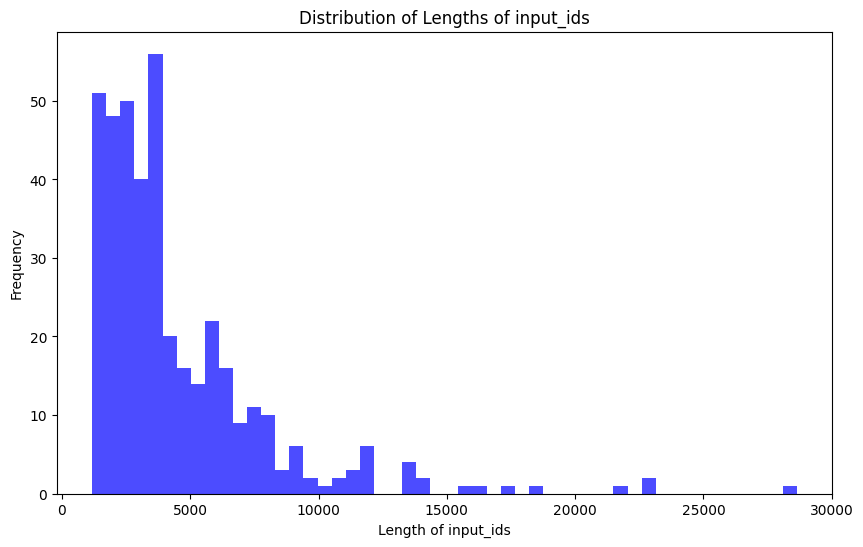

In [15]:
# Tokenize the dataset and store tokenized samples
data = dataset.map(lambda samples: tokenizer(samples['text']), batched=False)

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    """
    Plot the distribution of token lengths in the training and validation datasets.

    This function calculates the length of tokenized input texts in both the training and 
    validation datasets, combines the lengths, and plots a histogram to visualize their distribution.

    Parameters:
    tokenized_train_dataset (Dataset): The tokenized training dataset.
    tokenized_val_dataset (Dataset): The tokenized validation dataset.

    Returns:
    None
    """
    # Calculate the lengths of tokenized texts in the training dataset
    lengths = [len(x['text']) for x in tokenized_train_dataset]
    # Add the lengths of tokenized texts in the validation dataset
    lengths += [len(x['text']) for x in tokenized_val_dataset]
    
    # Print the total number of lengths calculated
    print(len(lengths))

    # Plotting the histogram of token lengths
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    # Uncomment the line below to set x-axis limits, if needed
    # plt.xlim([0, 1500])
    plt.show()

# Plot the distribution of token lengths in the training and validation datasets
plot_data_lengths(data['train'], data['test'])

In [16]:
# Define the maximum number of tokens allowed
max_tokens = 2048

# Function to calculate the number of tokens in a text
def count_tokens(text):
    """
    Calculate the number of tokens in a given text using the tokenizer.

    Parameters:
    text (str): The input text to be tokenized.

    Returns:
    int: The number of tokens in the input text.
    """
    return len(tokenizer.encode(text))

# Filter the dataset to include only tasks with a number of tokens within the allowed limit
filtered_train_dataset = dataset['train'].filter(lambda x: count_tokens(x['text']) <= max_tokens)
filtered_eval_dataset = dataset['test'].filter(lambda x: count_tokens(x['text']) <= max_tokens)

# Calculate the number of tasks filtered out
filtered_out_train_tasks = len(dataset['train']) - len(filtered_train_dataset)
filtered_out_eval_tasks = len(dataset['test']) - len(filtered_eval_dataset)

# Print the number of tasks filtered out and the remaining tasks
print(f'{filtered_out_train_tasks} training tasks were filtered out because they exceed the {max_tokens} token limit.')
print(f'The filtered training dataset contains {len(filtered_train_dataset)} tasks for fine-tuning.')
print(f'{filtered_out_eval_tasks} evaluation tasks were filtered out because they exceed the {max_tokens} token limit.')
print(f'The filtered evaluation dataset contains {len(filtered_eval_dataset)} tasks for evaluation.')


Filter: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 528.88 examples/s]

188 training tasks were filtered out because they exceed the 2048 token limit.
The filtered training dataset contains 132 tasks for fine-tuning.
42 evaluation tasks were filtered out because they exceed the 2048 token limit.
The filtered evaluation dataset contains 38 tasks for evaluation.


In [17]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)
pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto"
)

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

# pipeline(dataset['train'][0]['text'], max_new_tokens=1000, return_full_text=False)

prompt = filtered_eval_dataset[0]['text']

outputs = pipeline(
    prompt,
    max_new_tokens=512,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
print(outputs[0]["generated_text"][len(prompt):])

assistant

I've solved the puzzle based on the rules learned from the training data.


In [18]:
# Configure LoRA (Low-Rank Adaptation) for fine-tuning the model
peft_config = LoraConfig(
        lora_alpha=64,  # Scaling factor for the low-rank matrices
        lora_dropout=0.05,  # Dropout rate to apply to the low-rank matrices
        r=4,  # Rank of the low-rank matrices
        bias="none",  # Type of bias to use (none, all, or some specific layers)
        task_type="CAUSAL_LM",  # Specify the type of task (e.g., CAUSAL_LM for causal language modeling)
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj",  # List of modules to apply LoRA to
                        "gate_proj", "up_proj", "down_proj"],
)

# Explanation of LoRA Configuration Parameters:
# lora_alpha: Controls the scaling of the low-rank adaptation, helping to balance between original weights and the adapted ones.
# lora_dropout: Introduces dropout to the low-rank adaptation matrices, aiding in regularization.
# r: Defines the rank of the low-rank matrices, controlling the number of parameters added.
# bias: Determines whether and where to apply bias in the adapted model.
# task_type: Specifies the type of task for fine-tuning (CAUSAL_LM for causal language modeling in this case).
# target_modules: Lists the specific modules of the model where LoRA will be applied, focusing the adaptation on critical components.


In [25]:
# Define the output directory for the fine-tuned model
output_dir="llama3_8b_arc_v01"

sft_config = SFTConfig(
    output_dir=output_dir,  # Directory to save the fine-tuned model and checkpoints
    eval_strategy="steps",  # Evaluate the model at regular steps
    do_eval=True,  # Perform evaluation during training
    optim="paged_adamw_8bit",  # Optimizer to use for training (paged AdamW with 8-bit precision)
    per_device_train_batch_size=1,  # Training batch size per device
    gradient_accumulation_steps=8,  # Accumulate gradients over multiple steps to effectively increase batch size
    per_device_eval_batch_size=1,  # Evaluation batch size per device
    log_level="debug",  # Logging level (debug for detailed logs)
    save_steps=250,  # Save model checkpoint every 100 steps
    logging_steps=10,  # Log training metrics every step
    learning_rate=8e-6,  # Learning rate for the optimizer
    eval_steps=250,  # Evaluate the model every 100 steps
    max_steps=750,  # Maximum number of training steps
    num_train_epochs=3,  # Number of training epochs
    warmup_steps=10,  # Number of warmup steps for learning rate scheduler
    lr_scheduler_type="cosine",  # Type of learning rate scheduler (cosine annealing)
    fp16=True,  # Use 16-bit floating point precision for training
    bf16=False,  # Do not use bfloat16 precision
    max_grad_norm=0.3,  # Maximum gradient norm for gradient clipping
    gradient_checkpointing=True,  # Use gradient checkpointing to save memory
    gradient_checkpointing_kwargs={'use_reentrant':False},  # Arguments for gradient checkpointing
    ######
    dataset_text_field="text", # The field in the dataset containing the text data
    max_seq_length=max_tokens,  # The maximum sequence length for tokenization
    packing=False,
    report_to="none"
)

PyTorch: setting up devices


In [26]:
# Enable Weights & Biases (wandb) for tracking the training process
os.environ['WANDB_DISABLED'] = 'true'
#os.environ["WANDB_PROJECT"] = "llama3_8b_ARC"

In [27]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)
# Set up the SFTTrainer for fine-tuning the model
# Define the output directory for the fine-tuned model
output_dir="../models/finetune/llama3_8b_arc_v02"

trainer = SFTTrainer(
        model=model,  # The pre-trained model to be fine-tuned
        train_dataset=filtered_train_dataset,  # The training dataset
        eval_dataset=filtered_eval_dataset,  # The evaluation dataset
        peft_config=peft_config,  # LoRA configuration for parameter-efficient fine-tuning
        tokenizer=tokenizer,  # The tokenizer for the model
        args=sft_config,  # Training arguments configuration
)

# Print the number of trainable parameters in the model
trainer.model.print_trainable_parameters()

# Start the training process
trainer.train()

# Save the fine-tuned model
trainer.model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

PyTorch: setting up devices
Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 2684.26 examples/s]
max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
Currently training with a batch size of: 1
***** Running training *****
  Num examples = 132
  Num Epochs = 47
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 8
  Total optimization steps = 750
  Number of trainable parameters = 10,485,760


trainable params: 10,485,760 || all params: 8,040,747,008 || trainable%: 0.1304


Step,Training Loss,Validation Loss
250,0.107900,0.181301
500,0.038100,0.250031
750,0.022100,0.294249



***** Running Evaluation *****
  Num examples = 38
  Batch size = 1
Saving model checkpoint to llama3_8b_arc_v01/checkpoint-250
loading configuration file config.json from cache at /home/vishwak/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-instruct/snapshots/e1945c40cd546c78e41f1151f4db032b271faeaa/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 500000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.42.0.dev0",
  "use_cache": true

Model and tokenizer saved to llama3_8b_arc_v01
